评：`PlanAndExecute`这个范式，感觉和上一章的`HierarchicalAgentTeam`结合起来，可以发挥很大的威力。我之前对`HierarchicalAgentTeam`范式提示词的调试，用`PlanAndExecute`可以很轻松解决

In [1]:
import './../../loadenv.mjs'

[Module: null prototype] {  }

# Define the State

In [2]:
import { Annotation } from '@langchain/langgraph'

const PlanExecuteState = Annotation.Root({
    input: Annotation<string>({
        reducer: (x, y) => y ?? x ?? '',
    }),
    plan: Annotation<string[]>({
        reducer: (x, y) => y ?? x ?? [],
    }),
    pastSteps: Annotation<[string, string][]>({
        reducer: (x, y) => x.concat(y),
    }),
    response: Annotation<string>({
        reducer: (x, y) => y ?? x,
    }),
})

# Define Tools

In [3]:
import { TavilySearchResults } from '@langchain/community/tools/tavily_search'

const tools = [new TavilySearchResults({ maxResults: 3 })]

# Define out Execution Agent

In [4]:
import { getModel } from './../../utils.mjs'
import { createReactAgent } from '@langchain/langgraph/prebuilt'

const agentExecutor = createReactAgent({
    llm: getModel(),
    tools,
})

In [5]:
import { HumanMessage } from '@langchain/core/messages'

// await agentExecutor.invoke({
//     messages: [
//         new HumanMessage('who is the winner of the us open')
//     ]
// })

# Planning Step

In [6]:
import { z } from 'zod'
import { zodToJsonSchema } from 'zod-to-json-schema'

const plan = zodToJsonSchema(
    z.object({
        steps: z
            .array(z.string())
            .describe('different steps to follow, should be in sorted order')
    })
)
const planFunction = {
    name: 'plan',
    description: 'This tool is used to plan the steps to follow',
    parameters: plan
}

const planTool = {
    type: 'function',
    function: planFunction,
}

In [7]:
import { ChatPromptTemplate } from '@langchain/core/prompts'

const plannerPrompt = ChatPromptTemplate.fromTemplate(
    `For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

{objective}`
)

const model = getModel().withStructuredOutput(planFunction)

const planner = plannerPrompt.pipe(model)

In [8]:
// await planner.invoke({
//     objective: 'What is the hometown of the current Australia open winner'
// })

# Re-Plan Step

In [9]:
import { JsonOutputToolsParser } from '@langchain/core/output_parsers/openai_tools'

const response = zodToJsonSchema(
    z.object({
        response: z.string().describe('Response to user.')
    })
)

const responseTool = {
    type: 'function',
    function: {
        name: 'response',
        description: 'Response to user.',
        parameters: response,
    }
}

const replannerPrompt = ChatPromptTemplate.fromTemplate(
`For the given objective, come up with a simple step by step plan. 
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps.
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{pastSteps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that and use the 'response' function.
Otherwise, fill out the plan.  
Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.`,
)

const parser = new JsonOutputToolsParser()
const replanner = replannerPrompt
    .pipe(
        getModel().bindTools([
            planTool,
            responseTool,
        ])
    )
    .pipe(parser)

# Create the Graph

In [10]:
import { END, START, StateGraph } from '@langchain/langgraph'
import { RunnableConfig } from '@langchain/core/runnables'

async function executeStep(
    state: typeof PlanExecuteState.State,
    config?: RunnableConfig,
): Promise<Partial<typeof PlanExecuteState.State>> {
    const task = state.plan[0]
    const input = {
        messages: [new HumanMessage(task)],
    }
    const { messages } = await agentExecutor.invoke(input, config)
    return {
        pastSteps: [[task, messages[messages.length - 1].content.toString()]],
        plan: state.plan.slice(1),
    }
}

async function planStep(
    state: typeof PlanExecuteState.State,
): Promise<Partial<typeof PlanExecuteState.State>> {
    const plan = await planner.invoke({ objective: state.input })
    return {
        plan: plan.steps,
    }
}

async function replanStep(
    state: typeof PlanExecuteState.State,
): Promise<Partial<typeof PlanExecuteState.State>> {
    const output: any = await replanner.invoke({
        input: state.input,
        plan: state.plan.join('\n'),
        pastSteps: state.pastSteps
            .map(([step, result]) => `${step}: ${result}`)
            .join('\n')
    })
    const toolCall = output[0]

    if (toolCall.type === 'response') {
        return {
            response: toolCall.args?.response,
        }
    }
    return {
        plan: toolCall.args?.steps,
    }
}

function shouldEnd(state: typeof PlanExecuteState.State) {
    return state.response ? 'true' : 'false'
}

const workflow = new StateGraph(PlanExecuteState)
    .addNode('planner', planStep)
    .addNode('agent', executeStep)
    .addNode('replan', replanStep)
    .addEdge(START, 'planner')
    .addEdge('planner', 'agent')
    .addEdge('agent', 'replan')
    .addConditionalEdges('replan', shouldEnd, {
        true: END,
        false: 'agent',
    })
const app = workflow.compile()

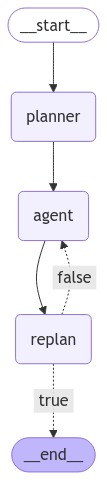

In [11]:
import { printGraph } from './../../utils.mjs'

await printGraph(app.getGraph())

In [12]:
const config = { recursionLimit: 50 }
const inputs = {
    input: 'what is the hometown of the 2024 Australian open winner?',
}
for await (const event of await app.stream(inputs, config)) {
    console.log(event)
}

{
  planner: {
    plan: [
      "Determine the winner of the 2024 Australian Open.",
      "Find the hometown information of the 2024 Australian Open winner."
    ]
  }
}
{
  agent: {
    pastSteps: [
      [
        "Determine the winner of the 2024 Australian Open.",
        "The winners of the 2024 Australian Open are as follows:\n" +
          "- **Men's Singles**: Jannick Sinner from Italy. He defeated Daniil Medvedev from Russia to win his first Grand Slam title. He also became the 27th different men’s singles winner in Melbourne since the Open era began in 1969 and the first Italian to achieve this feat.\n" +
          " - **Women's Singles**: Information was not in the provided search results, you may need to check other sources.\n" +
          " - **Men's Doubles**: Rohan Bopanna and Matthew Ebden. They defeated Simone Bolelli and Andrea Vavassori in the final with a score of 7–6(7–0), 7–5.\n" +
          " - **Women's Doubles**: Hsieh Su-wei and Elise Mertens. They defeated 

: 